In [1]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from dft_descriptors.prepocessing import preprocess
from featurisation import process_dataframe
from analysis import analysis_stratification_influence, analysis_train_set_size

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, BRICS, rdChemReactions
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
import math

In [2]:
df = pd.read_csv('data_csv/Data_test11042021.csv')
df = preprocess(df)
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [3]:
from featurisation import ligand_mapping, precursor_mapping, additives_mapping, one_hot_encoding, process_yield, rxnfp, origin_mapping
def process_dataframe_drop(df, drop='solvents'):
    
    solvents = one_hot_encoding(np.array(df["Solvent"]).reshape(-1, 1))
    ligands = one_hot_encoding(np.array([ligand_mapping(precursor) for precursor in df["Ligand effectif"]]).reshape(-1, 1))    
    precursors = one_hot_encoding(np.array([precursor_mapping(precursor) for precursor in df["Precurseur Nickel"]]).reshape(-1, 1))
    additives = one_hot_encoding(np.array([additives_mapping(precursor) for precursor in df["Base/additif après correction effective"]]).reshape(-1, 1))
    
    X = []
    yields = []
    DOIs = []
    mechanisms = []
    origins = []
    
    for i, row in df.iterrows():
        yield_isolated = process_yield(row["Isolated Yield"])
        yield_gc = process_yield(row['GC/NMR Yield'])
        # If both yields are known, we keep the isolated yield
        if yield_gc:
            y = yield_gc
        if yield_isolated:
            y = yield_isolated
        rxn_smarts = row["Reactant Smile (C-O)"] + '.' + row["A-X effectif"] + '>>' + row["Product"]
        reaction_fp = rxnfp(rxn_smarts)
        if drop == "solvent":
            feature_vector = np.concatenate((reaction_fp, ligands[i], precursors[i], additives[i]))
        elif drop == "ligand":
            feature_vector = np.concatenate((reaction_fp, solvents[i], precursors[i], additives[i]))
        elif drop == "rxn":
            feature_vector = np.concatenate((solvents[i], ligands[i], precursors[i], additives[i]))
        elif drop == "precursor":
            feature_vector = np.concatenate((reaction_fp, solvents[i], ligands[i], additives[i]))
        elif drop == "additive":
            feature_vector = np.concatenate((reaction_fp, solvents[i], ligands[i], precursors[i]))
        X.append(feature_vector)
        yields.append(y)
        DOIs.append(row["DOI"])
        mechanisms.append(row["Mechanism"])
        origins.append(origin_mapping(row['type of data (Optimisation or scope)']))
    
    return np.array(X), np.array(yields), np.array(DOIs), np.array(mechanisms), np.array(origins)

In [4]:
X, y, DOIs, mechanisms, origins = process_dataframe(df)

In [5]:
def categorize_y(y):
    categories = []
    for value in y:
        if value>75:
            categories.append(2)
        elif value<25:
            categories.append(0)
        else:
            categories.append(1)
    return np.array(categories)

In [6]:
estimators = RandomForestClassifier()
pipe = RandomForestClassifier()
metric = accuracy_score

# 1. Yields distribution by origin and mechanism

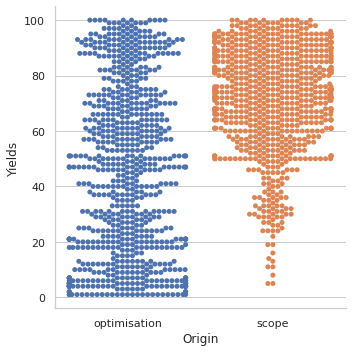

In [7]:
# Yield distribution according to scope/optimization
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

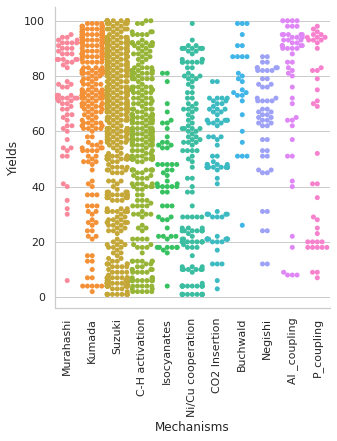

In [8]:
# Yield distribution according to mechanism
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [9]:
categorize_y(y)

array([1, 1, 1, ..., 2, 2, 2])

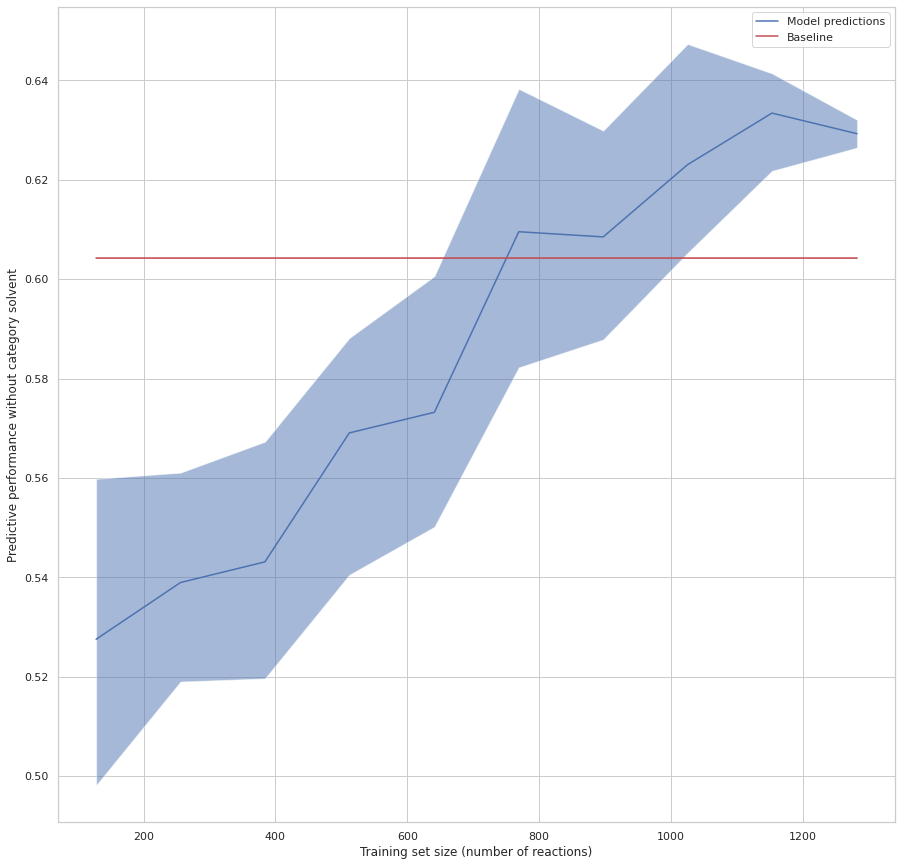

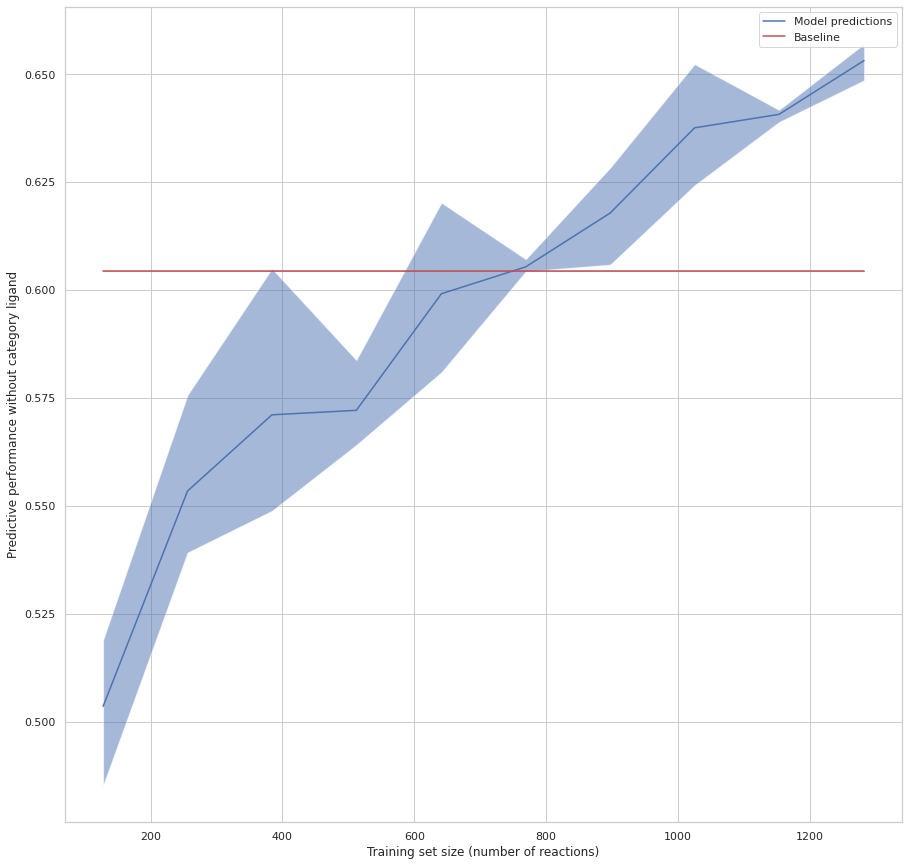

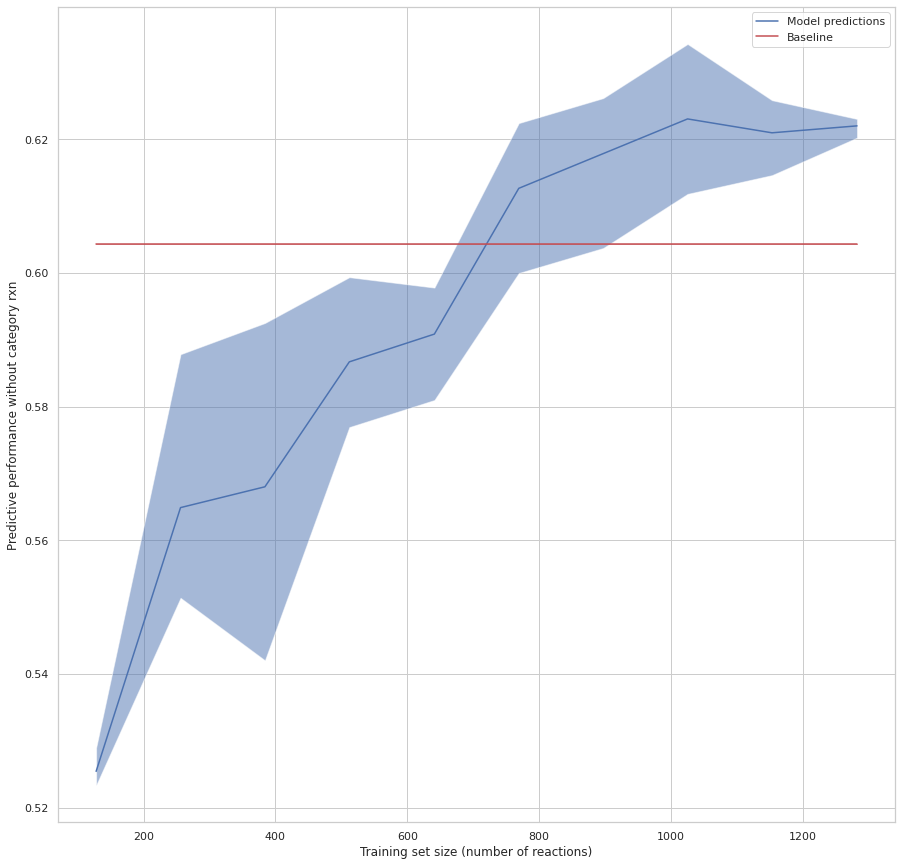

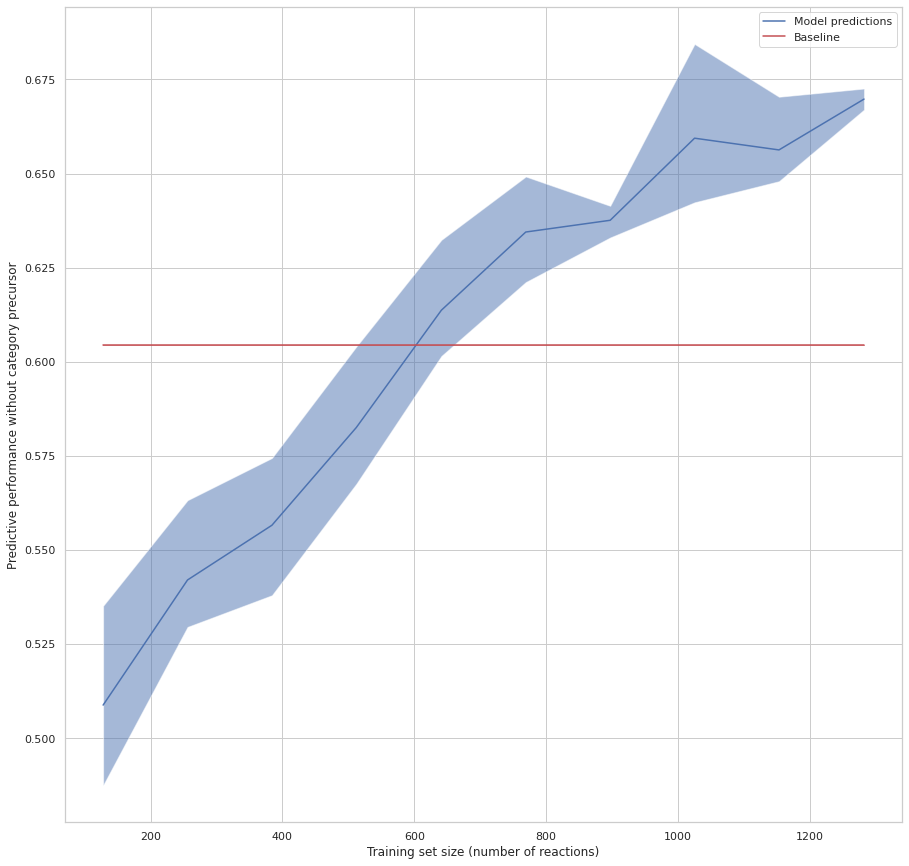

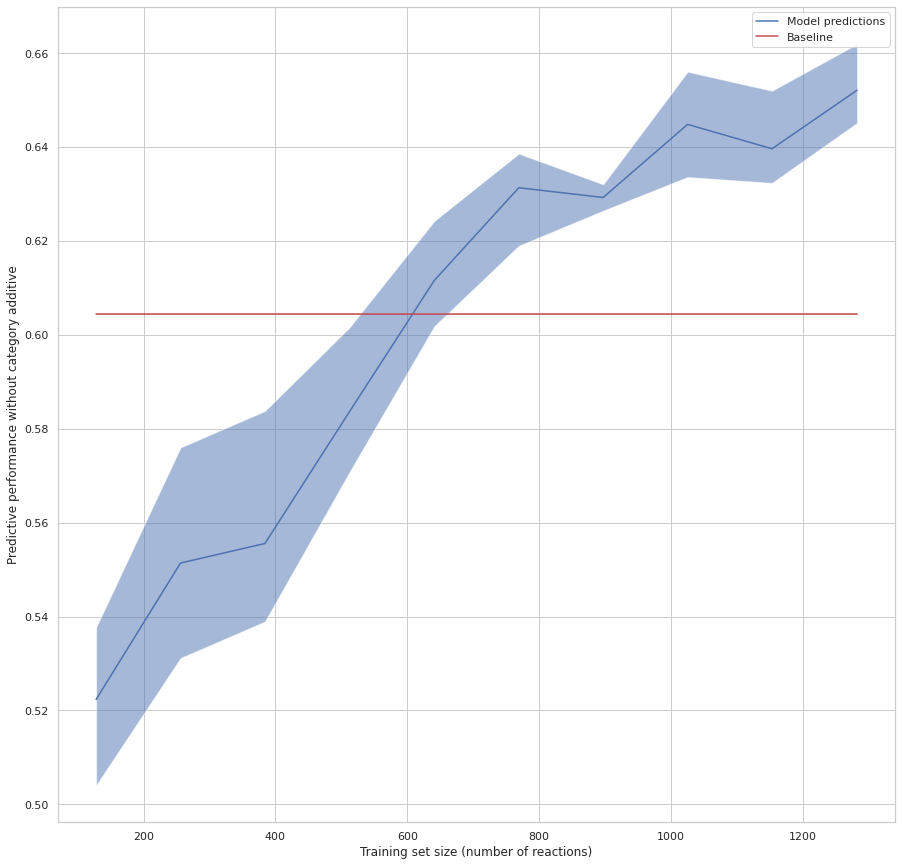

In [10]:
categories = ["solvent", "ligand", "rxn", "precursor", "additive"]

for category in categories:
    X, y, DOIs, mechanisms, origins = process_dataframe_drop(df, drop=category)
    metric_values, baseline_values, sizes = analysis_train_set_size(X, categorize_y(y), DOIs, metric=metric, predictor=pipe, n_iterations_external=1, n_iterations_internal=3)
    metric_mean = np.mean(metric_values, axis=1)
    metric_lower = np.percentile(metric_values, 5, axis=1)
    metric_upper = np.percentile(metric_values, 95, axis=1)

    baseline_mean = np.mean(baseline_values, axis=1)
    baseline_lower = np.percentile(baseline_values, 5, axis=1)
    baseline_upper = np.percentile(baseline_values, 95, axis=1)
    
    # How does (with fixed test set) performance improves as the training set size augments?
    plt.figure(figsize=(15, 15))
    plt.plot(sizes, metric_mean, label='Model predictions')
    plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

    plt.plot(sizes, baseline_mean, c='r', label='Baseline')
    plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

    plt.xlabel("Training set size (number of reactions)")
    plt.ylabel("Predictive performance without category " + category)

    plt.legend()
    plt.show()


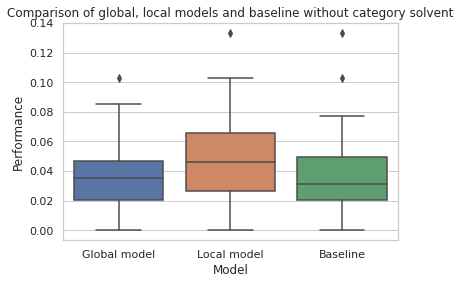

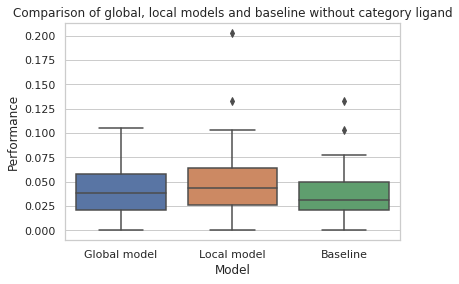

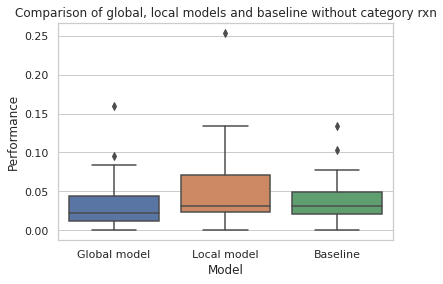

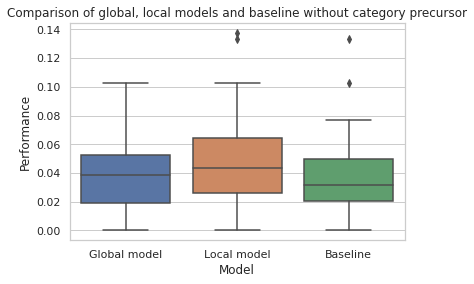

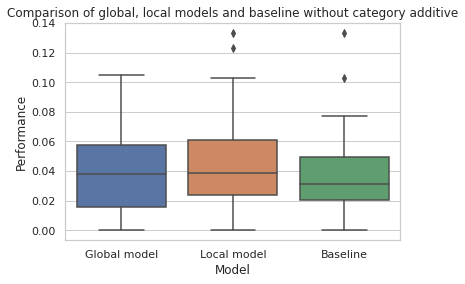

In [11]:
categories = ["solvent", "ligand", "rxn", "precursor", "additive"]
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

for category in categories:
    X, y, DOIs, mechanisms, origins = process_dataframe_drop(df, drop=category)
    metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, DOIs, metric=metric, predictor = pipe, test_size=0.95, n_iterations=3)
    metric_augmented = np.mean(metric_augmented, axis=1)
    metric_standalone = np.mean(metric_standalone, axis=1)
    metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


    mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
    orig = [doi_2_origin(DOIs, x) for x in unique_stratification]
    # Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism
    global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
    local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
    baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

    display_df = pd.concat([global_df, local_df, baseline_df])

    # Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models 

    plt.title("Comparison of global, local models and baseline without category " + category)
    chart = sns.boxplot(x = 'Model', y="Performance",  data=display_df, dodge=True)
    plt.show()